### Задание:
Необходимо разработать программу, обеспечивающую кластеризацию новостного потока с сайта [
https://www.newsvl.ru/](https://www.newsvl.ru/vlad/2019/01/19/). 
Некоторые новостные ленты содержат в себе тематические пометы. Необходимо выбрать новостную ленту с такими пометами, загрузить с нее новости, провести их кластеризацию и проверить точность кластеризации по тематическим пометам.

### Требования к заданию:
1. выгрузить новостную ленту с тематическими пометками;
2. векторизовать тексты новостей;
3. кластеризовать векторы новостей;
4. выбрать число кластеров одним из методов оценки (локтя, Дэвиса-Болдуина, …), оценить качество кластеризации по RAND Index;
5. оформить всё в виде работоспособной программы.

### Загрузка новостей

In [125]:
import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
from datetime import date
from datetime import timedelta
from tqdm import tqdm

Выделим заголовок и текст из новостной страницы

In [128]:
def get_news_text(url):
    page_text = requests.get(url).text
    bs=BeautifulSoup(page_text, "html.parser")
    title = None
    # Заголовок
    title = bs.h1.text
    # Сам текст
    whole_text = bs.find_all('div', 'story__text')
    text = None
    for i in range(len(whole_text)):
        text = " ".join([p.text for p in whole_text[i].find_all("p")])
        if not text:
            text = " ".join(whole_text[i].text.split('\n\n'))
    # Тэг
    parts = url.split('/')
    tag = parts[3]
    # Дата
    date = '/'.join(parts[4:7])
    return {'title': title, 
            'text': text,
            'date': date,
            'tag' : tag}   

Переберем все страницы в цикле

In [41]:
def get_page_news_links(page):
    links = []
    
    # Формируем url страницы со списком новостей
    url_root = 'https://www.newsvl.ru'
    url = url_root + '/?page=' + str(page) 
    
    # получаем текст страницы
    page_text = requests.get(url).text
    bs=BeautifulSoup(page_text, "html.parser")
    
    # ветви дерева с новостями
    whole_text = bs.find_all('div', 'story-list__item')
    for i in range(len(whole_text)):
        # ссылки на новости начинаются с тега h3
        item_title = whole_text[i].find_all("h3")
        for j in range(len(item_title)):
            # Вытаскиваем ссылки в тегах a
            link = item_title[0].find('a').get('href')
            links.append(url_root + link)
    return links

In [132]:
 # Сохраняем статьи в файл.
def saveArticle(filename, art):
    newsfile=open(filename, 'a', encoding='utf-8')
    title = str(art['title']).encode().decode('utf-8')
    text = str(art['text']).encode().decode('utf-8')
    date = str(art['date']).encode().decode('utf-8')
    tag = str(art['tag']).encode().decode('utf-8')
    text = text.strip('\n')
    text = text.strip()
    newsfile.write('\n=====\n'+title)
    newsfile.write('\n' + date)
    newsfile.write('\n' + tag)
    newsfile.write('\n-----\n'+text)
    newsfile.close()

In [261]:
filename = r'D:\hse_iot\ml_hse_2020\data\articles_LR3.txt'
newsfile=open(filename, 'w', encoding='utf-8')
newsfile.close()


# Определяем количество страниц в ленте и общее количество новостей
page_text = requests.get(r'https://www.newsvl.ru/').text
bs=BeautifulSoup(page_text, "html.parser")
whole_text = bs.find_all('div', 'pagination')
count_pages = int(whole_text[-1].text[whole_text[-1].text.find('(') + 1 : whole_text[-1].text.find(' страница, ')])
count_news = int(whole_text[-1].text[whole_text[-1].text.find(' страница, ') + len(' страница, ') :  whole_text[-1].text.find(' новость)')])

start_page = 1
stop_page = 30
counter = 1
for page in tqdm(range(start_page, stop_page + 1)):
    links_list = []
    links_list = get_page_news_links(page)
    for step, link in enumerate(links_list):
        try:
            res = get_news_text(link)
            saveArticle(filename, res)
        except Exception as err:
            print(err)
            print('Page: ' + str(page))
            print('step: ' + str(step))
        counter += 1
print(str(counter - 1) + ' news from ' + str(count_news))


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [33:28<00:00, 66.93s/it]

2949 news from 129541


### Обработка

In [163]:
from tqdm import tqdm
import pymorphy2 # Морфологический анализатор.
import re
import pandas as pd
import os.path

import matplotlib.pyplot as plt

In [262]:
%%time
news_file_path = r'D:\hse_iot\ml_hse_2020\data\articles_LR3.txt'

if os.path.exists(news_file_path):    
    newsfile = open(news_file_path, 'r', encoding="utf-8")
    text_news = [(n.split("\n-----\n")[0].split('\n')[0], 
                  n.split("\n-----\n")[0].split('\n')[1],
                  n.split("\n-----\n")[0].split('\n')[2],
                  n.split("\n-----\n")[1]) for n in newsfile.read().split("\n=====\n")[1:]]
    news = pd.DataFrame(text_news, columns = ['Header', 'Date', 'Tag', 'News'])
    newsfile.close()
    print('news read')
else:
    print('news file doesn\'t exist!')

news read
Wall time: 91.7 ms


In [264]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2949 entries, 0 to 2948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Header  2949 non-null   object
 1   Date    2949 non-null   object
 2   Tag     2949 non-null   object
 3   News    2949 non-null   object
dtypes: object(4)
memory usage: 92.3+ KB


In [265]:
news.head()

,Header,Date,Tag,News
0,В аэропорту Владивостока задерживаются рейсы и...,2020/11/15,vlad,"В воскресенье, 15 ноября, в аэропорт Владивост..."
1,Сегодня во Владивостоке 10…12 °C,2020/11/15,vlad,"Сегодня, 15 ноября, во Владивостоке южный, юго..."
2,Пережить коронавирус: почему в Приморье лучше ...,2020/11/14,covid19,"Власти признают, что проблемы с лечением корон..."
3,Субботний протест продолжается: пикеты во Влад...,2020/11/14,vlad,"В субботу, 14 ноября, около 40 человек собрали..."
4,Военный губернатор и его резиденция: как немец...,2020/11/14,history,"Ирония Владивостока в том, что многие вещи, до..."


In [267]:
news.reset_index(drop=True, inplace=True)

In [268]:
def print_article(num):
    print(news.Date.iloc[num])
    print('#' + news.Tag.iloc[num])
    print(news.Header.iloc[num])
    print('------')
    print(news.News.iloc[num])
print_article(398)

2020/11/02
#vlad
Рейсы из Владивостока в Японию будут летать по воскресеньям
------
Из Владивостока в Токио снова летают регулярные рейсы. Их выполняет авиакомпания «Аврора». Первым рейсом после длительного перерыва 1 ноября в Японию вылетели более 100 пассажиров. Первый регулярный пассажирский рейс по маршруту Владивосток – Токио (Нарита) – Владивосток состоялся 1 ноября. Из Владивостока в Токио вылетели 116 пассажиров. Обратным рейсом из Токио во Владивосток прибыли 59 человек. Рейсы будут выполняться раз в неделю – по воскресеньям, сообщает пресс-служба авиакомпании «Аврора». Отметим, в Японии, по состоянию на 1 ноября, зарегистрировано 101 146 случаев заражения коронавирусом, из них 754 – за последние сутки. В России 1 636 781 подтверждённый случай, 18 665 – за последние сутки. В Приморье 15 769 и 202 заражённых соответственно. Напомним, регулярное международное авиасообщение было прекращено с 27 марта из-за пандемии коронавируса. С апреля из-за границы прибывали только специально 

### Используем предобученную модель для векторизации  текстов

In [269]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

In [270]:
model_w2v = KeyedVectors.load_word2vec_format('data/araneum_upos_skipgram_300_2_2018.vec.gz')

In [271]:
morph = pymorphy2.MorphAnalyzer()
index2word_set = set(model_w2v.index2word)

# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy3(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

Векторизуеи тексты (как сумма векторов лемм, входящих в текст)

In [272]:
w2v_vectors = [text_to_vec(text) for text in news.News]

In [273]:
from umap import UMAP

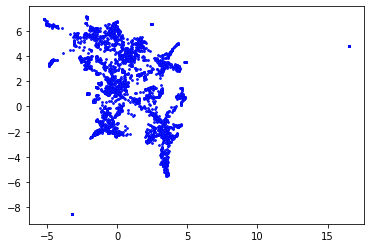

In [274]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(w2v_vectors)
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

Кластеризуем вектора

In [298]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from matplotlib.colors import ListedColormap
from numpy.random import choice
import seaborn as sns

plt.style.use('ggplot')

In [308]:
def get_key(value, vocabular_dict):
    for k, v in vocabular_dict.items():
        if v == value:
            return k

Проведем кластеризацию исходных векторов методом kmeans 

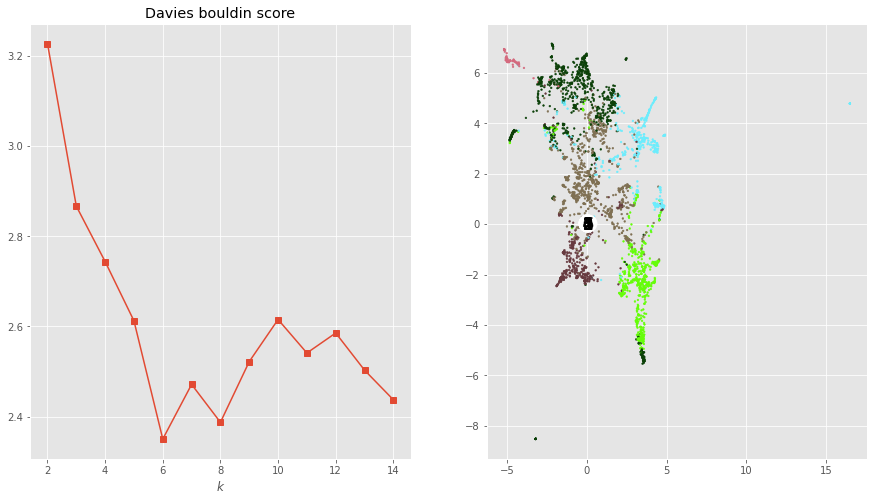

Adjusted Rand Index = 0.198409886716693
Best k = 6


In [334]:
dbs = []
max_k = 15 

tag_dict = {}
y = []
counter = 0

for tag in news.Tag:
    if not tag_dict.get(tag) and tag_dict.get(tag) != 0:
        tag_dict[tag] = counter
        counter +=1
    y.append(tag_dict[tag])

best_k = (2, 9999)
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(w2v_vectors)
    dbs_score = davies_bouldin_score(w2v_vectors, kmeans.labels_)
    dbs.append(dbs_score)
    if dbs_score < best_k[1]:
        best_k = (k, dbs_score)

kmeans = KMeans(n_clusters=best_k[0], random_state=1).fit(w2v_vectors)

fig, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].plot(range(2, max_k), dbs, marker='s')
ax[0].set_xlabel('$k$')
ax[0].set_title('Davies bouldin score')

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans.labels_)+1)) # Генерируем контрастную карту цветов.

ax[1].scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=kmeans.labels_, cmap=myclr)
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=300)
for i, c in enumerate(kmeans.cluster_centers_):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, c='black', s = 150)

plt.show()

print('Adjusted Rand Index = ' + str(adjusted_rand_score(kmeans.labels_, y)))
print('Best k = ' + str(best_k[0]))

Проведем кластеризацию методом kmeans в пространстве измененном при помощи UMAP

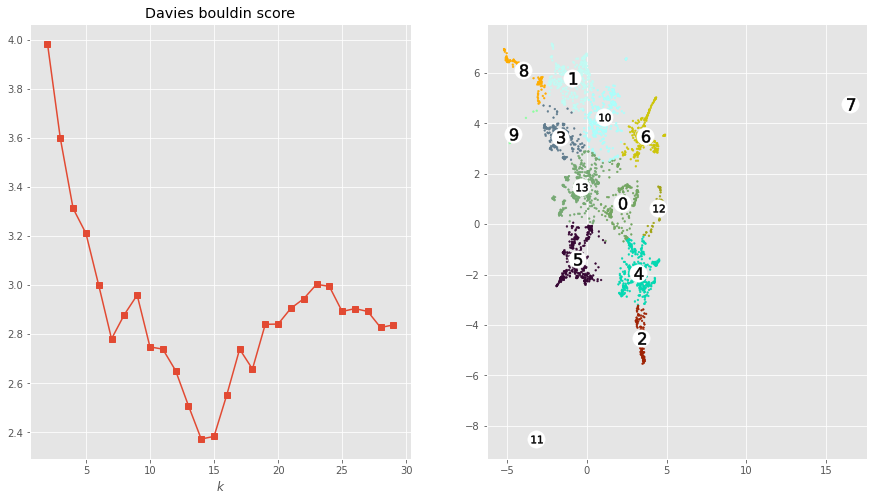

Adjusted Rand Index = 0.18115377800606805
Best k = 14


In [333]:
dbs = []
max_k = 30 

tag_dict = {}
y = []
counter = 0

for tag in news.Tag:
    if not tag_dict.get(tag) and tag_dict.get(tag) != 0:
        tag_dict[tag] = counter
        counter +=1
    y.append(tag_dict[tag])

best_k = (2, 9999)
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(umaped_vct)
    dbs_score = davies_bouldin_score(w2v_vectors, kmeans.labels_)
    dbs.append(dbs_score)
    if dbs_score < best_k[1]:
        best_k = (k, dbs_score)

kmeans = KMeans(n_clusters=best_k[0], random_state=1).fit(umaped_vct)

fig, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].plot(range(2, max_k), dbs, marker='s')
ax[0].set_xlabel('$k$')
ax[0].set_title('Davies bouldin score')

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans.labels_)+1)) # Генерируем контрастную карту цветов.

ax[1].scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=kmeans.labels_, cmap=myclr)
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=300)
for i, c in enumerate(kmeans.cluster_centers_):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, c='black', s = 150)


plt.show()

print('Adjusted Rand Index = ' + str(adjusted_rand_score(kmeans.labels_, y)))
print('Best k = ' + str(best_k[0]))

Проведем кластеризацию исходных векторов методом DBScan 

In [338]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph

In [339]:
# Строит разреженный граф, в котором на месте связей с ближайшими соседями стоят единицы.
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)

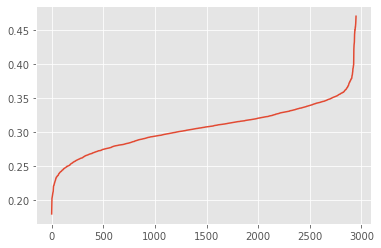

In [356]:
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
vpos=765
v1 = text_to_vec(news.News[vpos])

for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots()
ax.plot(range(len(neighbours)), neighbours)
plt.show()    

In [353]:
max(db.labels_)

0

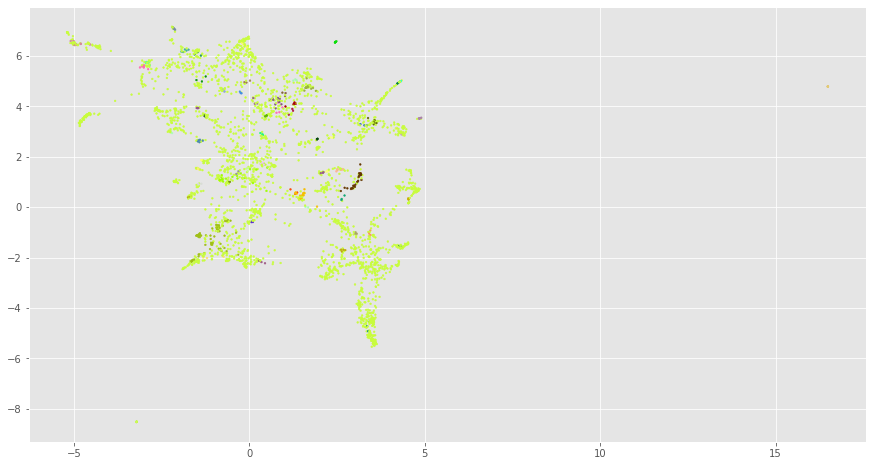

Adjusted Rand Index = 0.01761231940588729
Best eps = 0.11
Number of clusters = 63


In [397]:
best_rand = (0.1, 0)
for eps in range(10, 25):
    db=DBSCAN(eps=eps/100, min_samples=20).fit(w2v_vectors)
    rand = adjusted_rand_score(db.labels_, y)
    if rand > best_rand[1]:
        best_rand = (eps/100, rand)

db=DBSCAN(eps=best_rand[0], min_samples=3).fit(w2v_vectors)        
fig, ax = plt.subplots(figsize = (15, 8))

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db.labels_)+1)) # Генерируем контрастную карту цветов.

ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db.labels_, cmap=myclr)
plt.show()

print('Adjusted Rand Index = ' + str(best_rand[1]))
print('Best eps = ' + str(best_rand[0]))
print('Number of clusters = ' + str(max(db.labels_)))

In [358]:
# Строит разреженный граф, в котором на месте связей с ближайшими соседями стоят единицы.
wm = kneighbors_graph(umaped_vct, 3, n_jobs=-1)

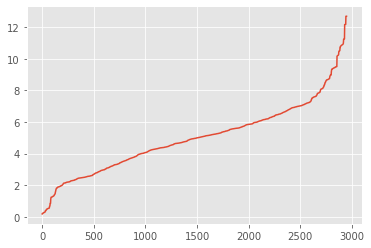

In [362]:
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
vpos=765
v1 = text_to_vec(news.News[vpos])

for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(umaped_vct[vpos]-umaped_vct[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots()
ax.plot(range(len(neighbours)), neighbours)
plt.show()    

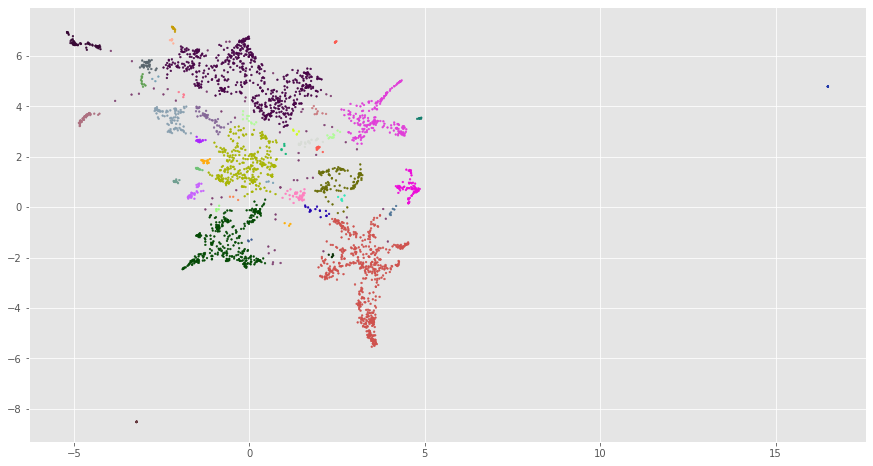

Adjusted Rand Index = 0.24800371274025265
Best eps = 0.2
Number of clusters = 43


In [380]:
best_rand = (0.1, 0)
for eps in range(10, 50):
    db=DBSCAN(eps=eps/100, min_samples=3).fit(umaped_vct)
    rand = adjusted_rand_score(db.labels_, y)
    if rand > best_rand[1]:
        best_rand = (eps/100, rand)

db=DBSCAN(eps=best_rand[0], min_samples=3).fit(umaped_vct)
fig, ax = plt.subplots(figsize = (15, 8))

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db.labels_)+1)) # Генерируем контрастную карту цветов.

ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db.labels_, cmap=myclr)
plt.show()

print('Adjusted Rand Index = ' + str(best_rand[1]))
print('Best eps = ' + str(best_rand[0]))
print('Number of clusters = ' + str(max(db.labels_)))